In [42]:
!git clone https://github.com/rslim087a/track

fatal: destination path 'track' already exists and is not an empty directory.


In [43]:
!ls selfdrivingData2

ls: cannot access 'selfdrivingData2': No such file or directory


In [44]:
!pip3 install imgaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Flatten, Dropout, MaxPooling2D, Convolution2D
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import ntpath
import pandas as pd
import random

In [46]:
datadir = 'track'
columns = ['center','left','right','steering','throttle','reverse','speed']
data = pd.read_csv(os.path.join(datadir,'driving_log.csv'),names=columns)
print(data.shape[0])
pd.set_option('display.max_colwidth',-1)
data.head()

4053


<ipython-input-46-0749b0f48216>:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth',-1)


center  \
0  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg   
1  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg   
2  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg   
3  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg   
4  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg   

                                                                   left  \
0  C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_382.jpg   
1  C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_670.jpg   
2  C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_724.jpg   
3  C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_792.jpg   
4  C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_860.jpg   

                                                                   right  \
0  C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_382.jpg   
1  C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_670.jpg   
2  C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_724.jpg   
3  C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_792.jpg   
4  C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_860.jpg   

   steering  throttle  reverse     speed  
0  0.0       0.0       0.0      0.649786  
1  0.0       0.0       0.0      0.627942  
2  0.0       0.0       0.0      0.622910  
3  0.0       0.0       0.0      0.619162  
4  0.0       0.0       0.0      0.615438

In [47]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center                              left  \
0  center_2018_07_16_17_11_43_382.jpg  left_2018_07_16_17_11_43_382.jpg   
1  center_2018_07_16_17_11_43_670.jpg  left_2018_07_16_17_11_43_670.jpg   
2  center_2018_07_16_17_11_43_724.jpg  left_2018_07_16_17_11_43_724.jpg   
3  center_2018_07_16_17_11_43_792.jpg  left_2018_07_16_17_11_43_792.jpg   
4  center_2018_07_16_17_11_43_860.jpg  left_2018_07_16_17_11_43_860.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2018_07_16_17_11_43_382.jpg  0.0       0.0       0.0      0.649786  
1  right_2018_07_16_17_11_43_670.jpg  0.0       0.0       0.0      0.627942  
2  right_2018_07_16_17_11_43_724.jpg  0.0       0.0       0.0      0.622910  
3  right_2018_07_16_17_11_43_792.jpg  0.0       0.0       0.0      0.619162  
4  right_2018_07_16_17_11_43_860.jpg  0.0       0.0       0.0      0.615438

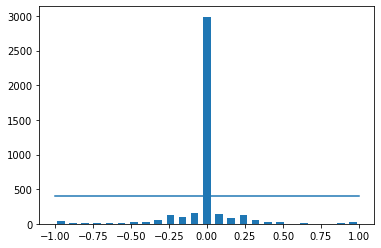

In [48]:
# a bin is a bar on the histogram
num_bins = 25
# don't want too many samples per bin (otherwise there is bias)
# in this case, too much 0 steering angles (car would only be able to drive straight)
samples_per_bin = 400
hist, bins = np.histogram(data['steering'],num_bins)
# to center the values around 0
center = (bins[:-1]+bins[1:]) * 0.5
plt.bar(center,hist,width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))

total data 4053
removed: 2590
remaining: 1463


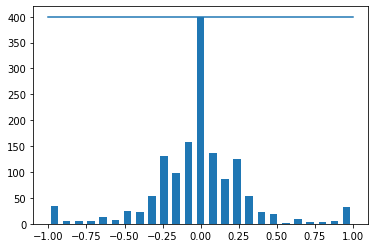

In [49]:
print('total data',len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
print('removed:',len(remove_list))
data.drop(data.index[remove_list],inplace=True)
print('remaining:',len(data))

hist, _ = np.histogram(data['steering'],num_bins)
plt.bar(center,hist,width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))


In [50]:
print(data.iloc[1])
def load_image_steering(datadir,df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center,left,right = indexed_data[0],indexed_data[1],indexed_data[2]
    image_path.append(os.path.join(datadir,center.strip()))
    steering.append(indexed_data[3])
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths,steerings

image_paths, steerings = load_image_steering(datadir+'/IMG',data)

center      center_2018_07_16_17_11_43_998.jpg
left        left_2018_07_16_17_11_43_998.jpg  
right       right_2018_07_16_17_11_43_998.jpg 
steering    0.0                               
throttle    0.0                               
reverse     0.0                               
speed       0.606834                          
Name: 6, dtype: object


In [51]:
# test size is the percentage of data that is used for testing instead of training
X_train, X_valid, y_train, y_valid = train_test_split(image_paths,steerings, test_size=0.2,random_state=6)
print("Training samples: {}\nValidation samples:{}".format(len(X_train),len(X_valid)))

Training samples: 1170
Validation samples:293


In [52]:
# arg 1: num rows
# arg 2: num columns

fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].hist(y_train,bins=num_bins,width=0.05,color='blue')
axs[0].set_title('Training set')
axs[1].hist(y_valid,bins=num_bins,width=0.05,color='red')
axs[1].set_title('Validation set')

Text(0.5, 1.0, 'Validation set')

In [53]:
def zoom(img):
  # zoom from 1x to 1.3x
  zoom = iaa.Affine(scale=(1,1.3)) 
  img = zoom.augment_image(img)
  return img

In [54]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig,axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original')

axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed')

Text(0.5, 1.0, 'Zoomed')

In [55]:
def pan(img):
  pan = iaa.Affine(translate_percent={"x":(-0.1,0.1), "y":(-0.1,0.1)})
  image = pan.augment_image(img)
  return image

Text(0.5, 1.0, 'Panned')

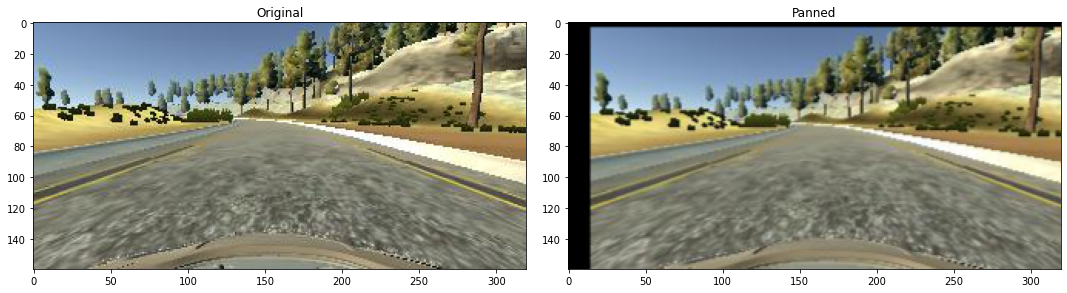

In [56]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig,axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original')

axs[1].imshow(panned_image)
axs[1].set_title('Panned')

In [57]:
def img_rand_brightness(img):
  brightness = iaa.Multiply((0.2,1.2))
  image = brightness.augment_image(img)
  return image

In [58]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
brightness_altered_img = img_rand_brightness(original_image)

fig,axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original')

axs[1].imshow(brightness_altered_img)
axs[1].set_title('Brightness altered')

Text(0.5, 1.0, 'Brightness altered')

In [59]:
def img_rand_flip(img,steering_angle):
  # if arg is 0, vertical flip
  # if arg is 1, horizontal (like we've chosen)
  # if arg is -1, both vertical and horizontal
  image = cv2.flip(img, 1)
  steering_angle = -steering_angle
  return image, steering_angle

Text(0.5, 1.0, 'Flipped image - Steering angle: 0.2350399')

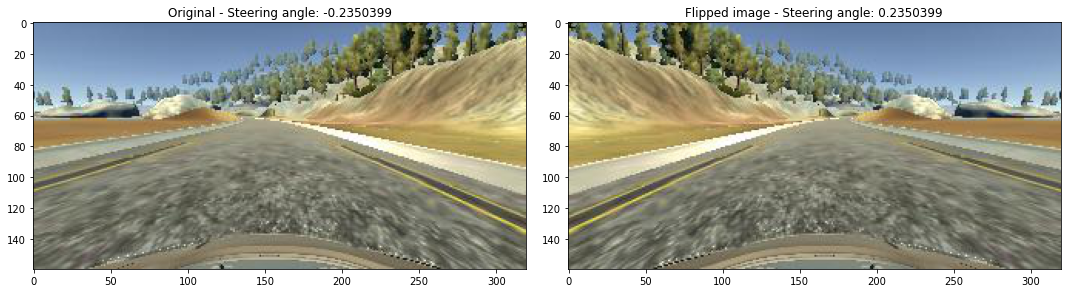

In [60]:
rand_index = random.randint(0,1000)
image = image_paths[rand_index]
steering_angle = steerings[rand_index]

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_rand_flip(original_image,steering_angle)

fig,axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original' + ' - Steering angle: ' + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped image' + ' - Steering angle: ' + str(flipped_steering_angle))

In [61]:
def rand_augment(image,steering_angle):
  image = mpimg.imread(image)
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = img_rand_brightness(image)
  if np.random.rand() < 0.5:
    image,steering_angle = img_rand_flip(image,steering_angle)
  return image,steering_angle


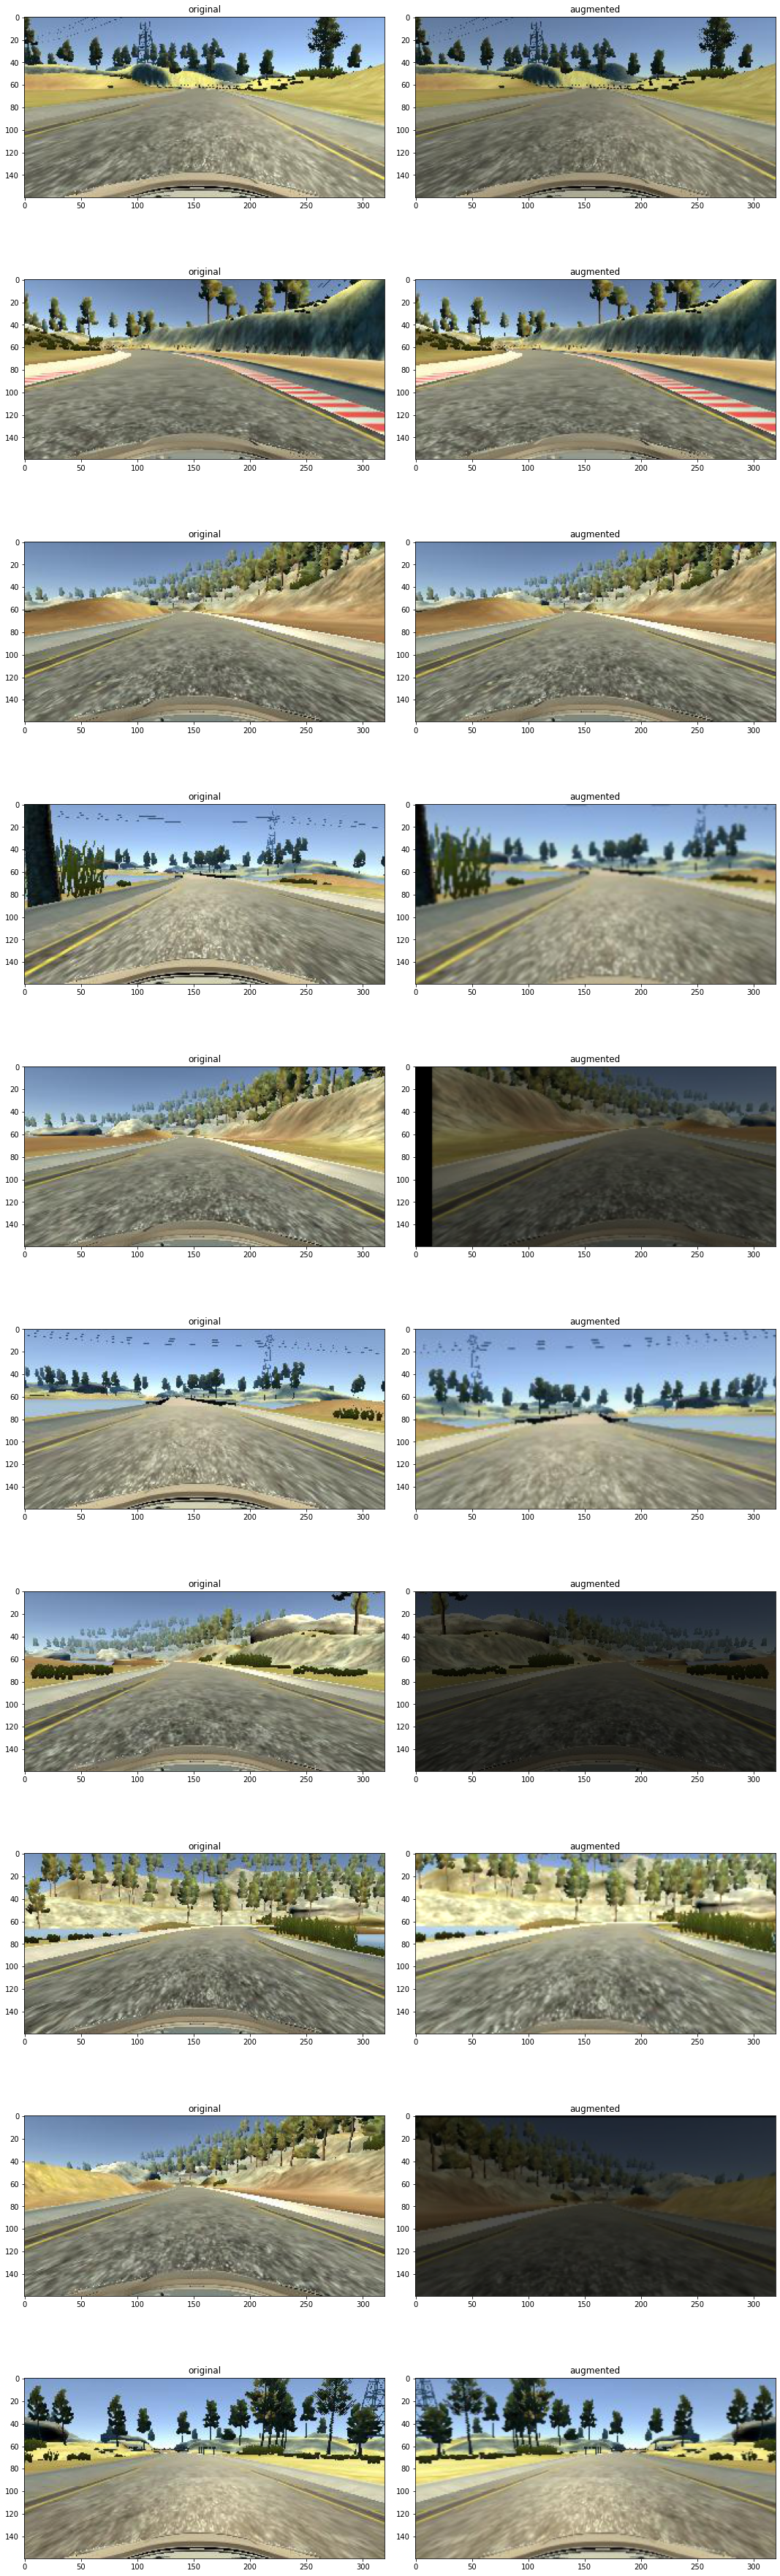

In [62]:
ncol = 2
nrow = 10
fig,axs = plt.subplots(nrow,ncol,figsize=(15,50))
fig.tight_layout()
for i in range(nrow):
  randnum = random.randint(0,len(image_paths)-1)
  rand_img = image_paths[randnum]
  rand_steering = steerings[randnum]

  orig_img = mpimg.imread(rand_img)
  augmented_img, steering = rand_augment(rand_img,rand_steering)

  axs[i][0].imshow(orig_img)
  axs[i][0].set_title("original")

  axs[i][1].imshow(augmented_img)
  axs[i][1].set_title("augmented")

In [63]:
def img_preprocess(img):
  # img = mpimg.imread(img_path)

  # crop image to remove unhelpful scenery and hood of car
  img = img[60:135,:,:]

  # using NVIDIA neural architecture (they recommend YUV colorscheme)
  img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)

  # smooth out image
  img = cv2.GaussianBlur(img,(3,3),0)
  
  # matches the input of the NVIDIA model architecture
  img = cv2.resize(img,(200,66))

  # normalizing
  img = img/255

  return img


In [64]:
def batch_generator(image_paths,steerings,batch_size,is_training):

  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      rand_index = random.randint(0,len(image_paths)-1)

      if is_training:
        img, steering = rand_augment(image_paths[rand_index],steerings[rand_index])
      else:
        img = mpimg.imread(image_paths[rand_index])
        steering = steerings[rand_index]
      
      image = img_preprocess(img)
      batch_img.append(image)
      batch_steering.append(steering)
    yield (np.asarray(batch_img),np.asarray(batch_steering))

Text(0.5, 1.0, 'Validation image')

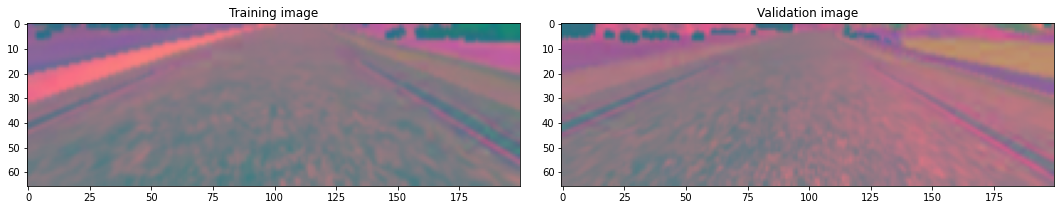

In [65]:
X_train_gen, y_train_gen = next(batch_generator(X_train,y_train,1,1))
X_valid_gen, y_valid_gen = next(batch_generator(X_valid,y_valid,1,0))

fig,axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(X_train_gen[0])
axs[0].set_title('Training image')

axs[1].imshow(X_valid_gen[0])
axs[1].set_title('Validation image')

Text(0.5, 1.0, 'Preprocessed image')

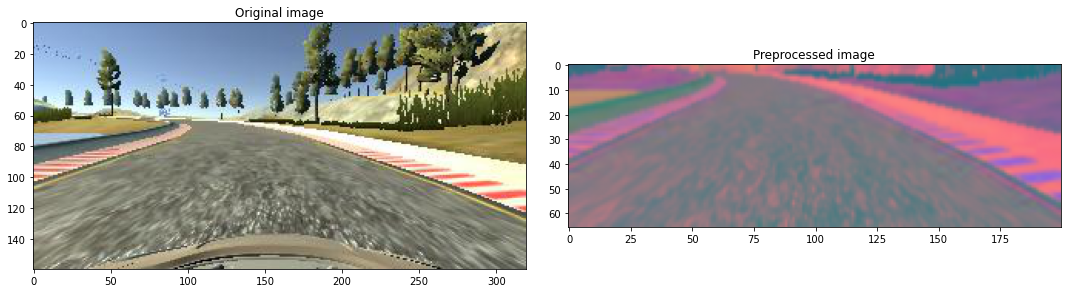

In [66]:
image = image_paths[200]
orig_image = mpimg.imread(image)
preprocessed_image = img_preprocess(orig_image)

fig,axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(orig_image)
axs[0].set_title("Original image")
axs[1].imshow(preprocessed_image)
axs[1].set_title("Preprocessed image")

In [67]:
# X_train = np.array(list(map(img_preprocess,X_train)))
# X_valid = np.array(list(map(img_preprocess,X_valid)))
# don't use this anymore since data is now created on the fly by batch generator

In [68]:
# plt.imshow(X_train[random.randint(0,len(X_train)-1)])
# plt.axis('off')
# print(X_train.shape)

In [69]:
def nvidia_model_relu():
  model = Sequential()
  # subsample refers to the stride length of kernel (first arg is horizontal translation, second is vertical one)
  model = Sequential()
  model.add(Convolution2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3),activation='relu'))
  model.add(Convolution2D(36, kernel_size=(5,5), strides=(2,2), activation='relu'))
  model.add(Convolution2D(48, kernel_size=(5,5), strides=(2,2), activation='relu'))
  model.add(Convolution2D(64, kernel_size=(3,3), activation='relu'))
  model.add(Convolution2D(64, kernel_size=(3,3), activation='relu'))
  # model.add(Dropout(0.2))

  # try changing arg to 0.1-0.2 (stack overflow suggests this is more effective for CNN layers)
  # https://stats.stackexchange.com/questions/240305/where-should-i-place-dropout-layers-in-a-neural-network
  # model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(100,activation='relu'))
  # model.add(Dropout(0.5))

  model.add(Dense(50,activation='relu'))
  # model.add(Dropout(0.5))

  model.add(Dense(10,activation='relu'))
  # model.add(Dropout(0.5))

  model.add(Dense(1))

  # optimizer = Adam(learning_rate=0.001)
  optimizer = Adam(learning_rate=1e-3)
  model.compile(loss='mse',optimizer=optimizer)

  return model


In [70]:
def nvidia_model_elu():
  # subsample refers to the stride length of kernel (first arg is horizontal translation, second is vertical one)
  model = Sequential()
  
  model.add(Convolution2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3),activation='elu'))
  model.add(Convolution2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Convolution2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Convolution2D(64, kernel_size=(3,3), activation='elu'))
  model.add(Convolution2D(64, kernel_size=(3,3), activation='elu'))
  # model.add(Dropout(0.2))

  # try changing arg to 0.1-0.2 (stack overflow suggests this is more effective for CNN layers)
  # https://stats.stackexchange.com/questions/240305/where-should-i-place-dropout-layers-in-a-neural-network
  # model.add(Dropout(0.5))

  model.add(Flatten())

  model.add(Dense(100,activation='elu'))
  # model.add(Dropout(0.5))

  model.add(Dense(50,activation='elu'))
  # model.add(Dropout(0.5))

  model.add(Dense(10,activation='elu'))
  # model.add(Dropout(0.5))

  model.add(Dense(1))

  # optimizer = Adam(learning_rate=0.001)
  optimizer = Adam(learning_rate=1e-3)
  model.compile(loss='mse',optimizer=optimizer)

  return model


In [71]:
relu_model = nvidia_model_relu()
elu_model = nvidia_model_elu()
print(relu_model.summary())
print(elu_model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 31, 98, 24)        1824      
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 47, 36)        21636     
                                                                 
 conv2d_12 (Conv2D)          (None, 5, 22, 48)         43248     
                                                                 
 conv2d_13 (Conv2D)          (None, 3, 20, 64)         27712     
                                                                 
 conv2d_14 (Conv2D)          (None, 1, 18, 64)         36928     
                                                                 
 flatten_2 (Flatten)         (None, 1152)              0         
                                                                 
 dense_8 (Dense)             (None, 100)              

In [72]:
# relu_history = relu_model.fit_generator(batch_generator(X_train,y_train,100,1),steps_per_epoch=300,epochs=10,validation_data=batch_generator(X_valid,y_valid,100,0),validation_steps=200,verbose=1,shuffle=1)
elu_history = elu_model.fit_generator(batch_generator(X_train,y_train,100,1),steps_per_epoch=300,epochs=10,validation_data=batch_generator(X_valid,y_valid,100,0),validation_steps=200,verbose=1,shuffle=1)

<ipython-input-72-5a9f8ae11acc>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  elu_history = elu_model.fit_generator(batch_generator(X_train,y_train,100,1),steps_per_epoch=300,epochs=10,validation_data=batch_generator(X_valid,y_valid,100,0),validation_steps=200,verbose=1,shuffle=1)


Epoch 1/10
300/300 [==============================] - 138s 459ms/step - loss: 0.1361 - val_loss: 0.0725
Epoch 2/10
300/300 [==============================] - 128s 428ms/step - loss: 0.0642 - val_loss: 0.0757
Epoch 3/10
300/300 [==============================] - 130s 433ms/step - loss: 0.0588 - val_loss: 0.0535
Epoch 4/10
300/300 [==============================] - 130s 433ms/step - loss: 0.0505 - val_loss: 0.0495
Epoch 5/10
300/300 [==============================] - 130s 433ms/step - loss: 0.0449 - val_loss: 0.0436
Epoch 6/10
300/300 [==============================] - 130s 434ms/step - loss: 0.0414 - val_loss: 0.0326
Epoch 7/10
300/300 [==============================] - 129s 433ms/step - loss: 0.0378 - val_loss: 0.0259
Epoch 8/10
300/300 [==============================] - 129s 431ms/step - loss: 0.0349 - val_loss: 0.0324
Epoch 9/10
300/300 [==============================] - 129s 432ms/step - loss: 0.0339 - val_loss: 0.0259
Epoch 10/10
300/300 [==============================] - 128s 427m

In [73]:
# fig, axs = plt.subplots(1,2,figsize=(12,4))

# # Relu
# axs[0].plot(relu_history.history['loss'])
# axs[0].plot(relu_history.history['val_loss'])
# axs[0].legend(['training','validation'])
# axs[0].set_title('Relu Loss')

# # Elu
# axs[1].plot(elu_history.history['loss'])
# axs[1].plot(elu_history.history['val_loss'])
# axs[1].legend(['training','validation'])
# axs[1].set_title('Elu Loss')

Text(0.5, 0, 'epoch')

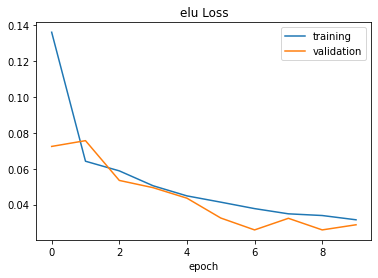

In [74]:
plt.plot(elu_history.history['loss'])
plt.plot(elu_history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('elu Loss')
plt.xlabel('epoch')

In [75]:
# plt.plot(relu_history.history['loss'])
# plt.plot(relu_history.history['val_loss'])
# plt.legend(['training','validation'])
# plt.title('Relu Loss')
# plt.xlabel('epoch')

In [76]:
# relu_model.save('relu_model.h5')
elu_model.save('elu_model.h5')

In [77]:
from google.colab import files
# files.download('relu_model.h5')
files.download('elu_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>